Combining all datasets to one dataset to easyly use ML methods

In [10]:
import pandas as pd

# upload the datasets
crashes = pd.read_csv("NYC Vehicle Crashes 2012 - 2023.csv", usecols=['CRASH DATE'], parse_dates=['CRASH DATE'])
weather_2019 = pd.read_csv("nyc_temperature.csv", usecols=['date', 'tavg', 'precipitation'])
weather_2020_2021 = pd.read_csv("NYC_Weather_2016_2022.csv", usecols=['time', 'temperature_2m (°C)', 'precipitation (mm)'])

# filtering crash data
crashes = crashes[(crashes['CRASH DATE'] >= '2019-01-01') & (crashes['CRASH DATE'] <= '2021-12-31')]
crash_counts = crashes.groupby('CRASH DATE').size().reset_index(name='num_crashes')

# 2019 weather data
weather_2019['date'] = pd.to_datetime(weather_2019['date'], format='%d/%m/%Y', errors='coerce')
weather_2019['tavg'] = pd.to_numeric(weather_2019['tavg'], errors='coerce')
weather_2019['precipitation'] = pd.to_numeric(weather_2019['precipitation'], errors='coerce')
weather_2019_daily = weather_2019.groupby('date')[['tavg', 'precipitation']].mean().reset_index()

# 2020–2021 weather data
weather_2020_2021['time'] = pd.to_datetime(weather_2020_2021['time'], errors='coerce')
weather_2020_2021 = weather_2020_2021[
    (weather_2020_2021['time'] >= '2020-01-01') & (weather_2020_2021['time'] <= '2021-12-31')
]
weather_2020_2021.rename(columns={
    'temperature_2m (°C)': 'tavg',
    'precipitation (mm)': 'precipitation'
}, inplace=True)
weather_2020_2021['date'] = pd.to_datetime(weather_2020_2021['time'].dt.date)
weather_2020_2021['tavg'] = pd.to_numeric(weather_2020_2021['tavg'], errors='coerce')
weather_2020_2021['precipitation'] = pd.to_numeric(weather_2020_2021['precipitation'], errors='coerce')
weather_2020_2021_daily = weather_2020_2021.groupby('date')[['tavg', 'precipitation']].mean().reset_index()

# combining weather data
weather_combined = pd.concat([weather_2019_daily, weather_2020_2021_daily], ignore_index=True)

# combining crash and weather data
final_df = pd.merge(crash_counts, weather_combined, left_on='CRASH DATE', right_on='date', how='left')
final_df.fillna(final_df.mean(numeric_only=True), inplace=True)
final_df.drop(columns=['date'], inplace=True)
final_df.dropna(inplace=True)

# data enrichment
final_df['bad_weather'] = ((final_df['precipitation'] > 3) | (final_df['tavg'] < 0)).astype(int)
final_df['temp_category'] = final_df['tavg'].apply(
    lambda temp: 'Very Cold' if temp < 0 else ('Cold' if temp < 10 else ('Mild' if temp < 20 else 'Warm'))
)
final_df['is_weekend'] = final_df['CRASH DATE'].dt.weekday.isin([5, 6]).astype(int)

# saving the final document to use ML methods later
final_df.to_csv("final_df_minimized.csv", index=False)


ML Modeling with Visualizations

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Load the prepared dataset

In [12]:
final_df = pd.read_csv("final_df_minimized.csv")

Feature matices and defining fetaures

In [13]:
# Defining features and target
X = final_df[['precipitation', 'tavg', 'is_weekend', 'bad_weather', 'temp_category']]
y = final_df['num_crashes']

# Numerical and Categorical Features
numeric_features = ['precipitation', 'tavg']
categorical_features = ['is_weekend', 'bad_weather', 'temp_category']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

ML Methods

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []
predictions_dict = {}

Training Models and Visualization

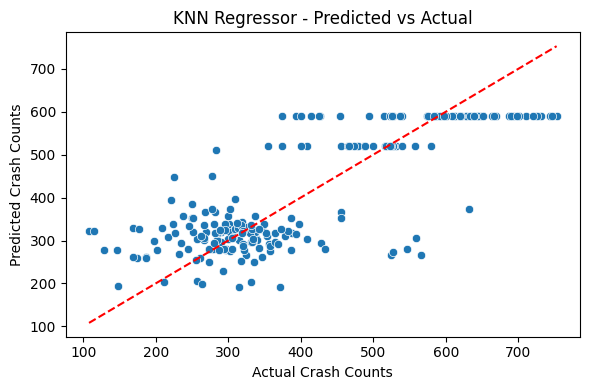

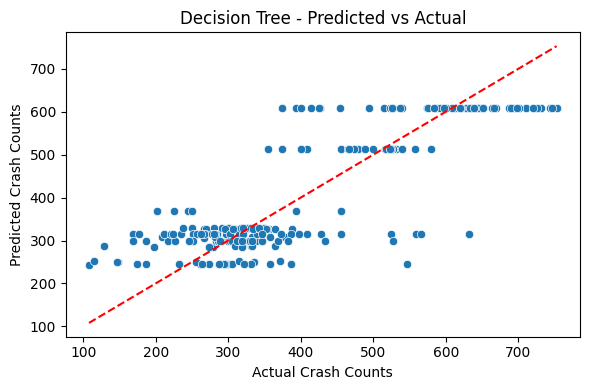

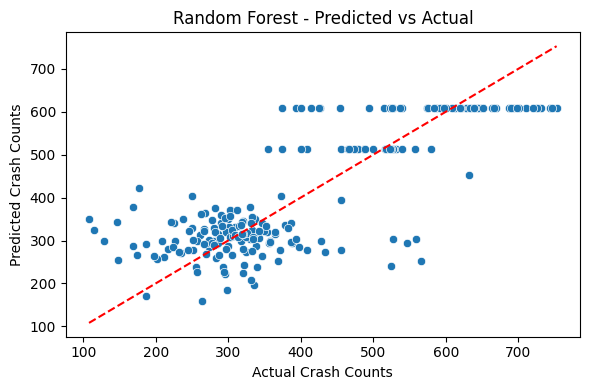

In [15]:
# Training and Evaluating Models
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    predictions_dict[name] = y_pred

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'R²': round(r2, 3)
    })

    # Scatter plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Crash Counts")
    plt.ylabel("Predicted Crash Counts")
    plt.title(f"{name} - Predicted vs Actual")
    plt.tight_layout()
    plt.show()

Comparison Table

Model Performance Comparison:
           Model   RMSE    MAE     R²
0  KNN Regressor  92.36  68.84  0.647
1  Decision Tree  85.40  62.69  0.698
2  Random Forest  90.88  67.26  0.658


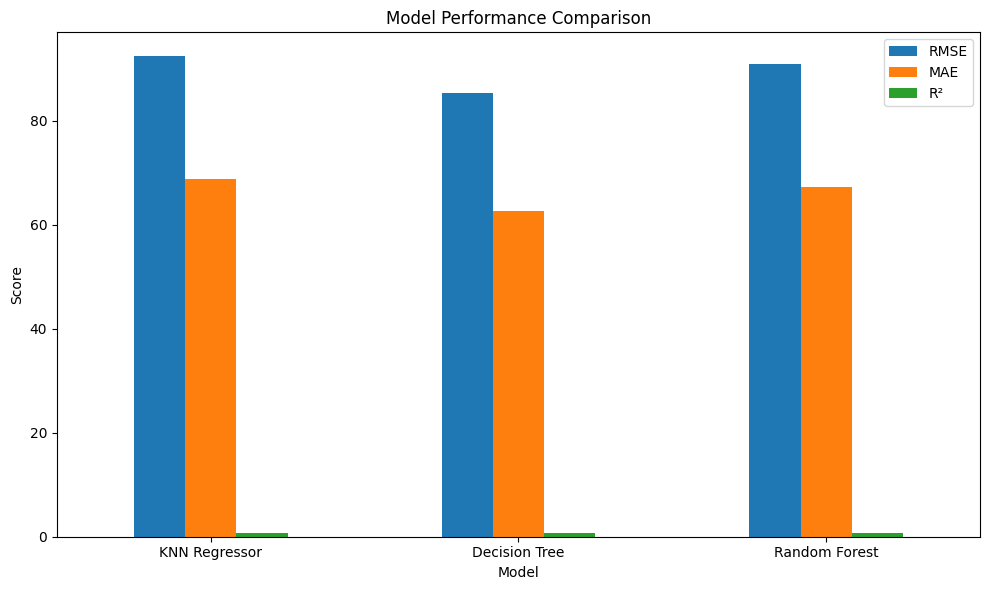

In [16]:
# Summary Comparison Table
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df)

# Plot performance metrics
metrics_df = results_df.set_index('Model')[['RMSE', 'MAE', 'R²']]
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Random Forest

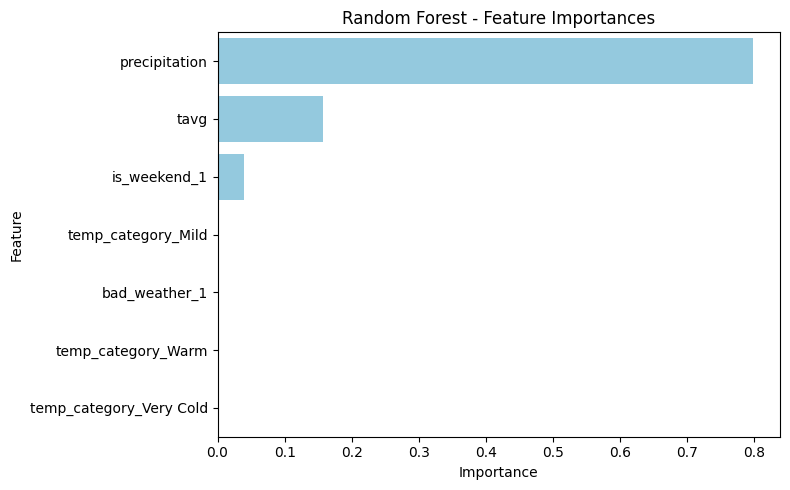

In [17]:
# Random Forest Feature Importances
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipe.fit(X_train, y_train)

ohe = rf_pipe.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(encoded_cat_names)
importances = rf_pipe.named_steps['model'].feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', color='skyblue')
plt.title("Random Forest - Feature Importances")
plt.tight_layout()
plt.show()

Decision Tree

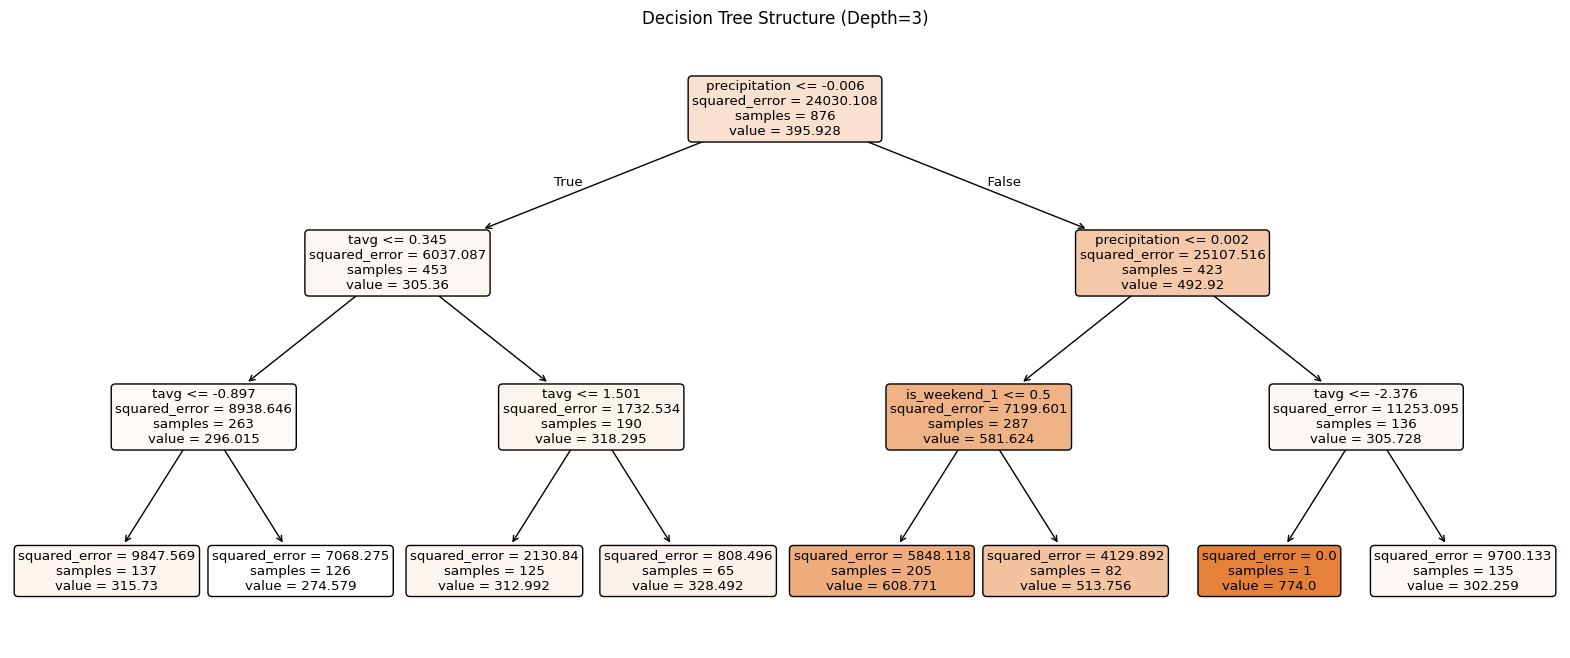

In [18]:
# Visualizing Decision Tree
tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=3, random_state=42))
])
tree_pipe.fit(X_train, y_train)

plt.figure(figsize=(20, 8))
plot_tree(tree_pipe.named_steps['model'], feature_names=feature_names, filled=True, rounded=True)
plt.title("Decision Tree Structure (Depth=3)")
plt.show()